In [1]:
import numpy as np
import torch
from torch import nn
import os
from numpy import *
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold 
import pandas as pd
from matplotlib.pyplot import MultipleLocator
import decoding 
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.autograd import Variable
import analysis
import timevarying
import shaping

/apps/pytorch/1.8.1/lib/python3.9/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
jobid=2
name_list=['IA1','IA2','IA3','IJ1','IJ2','AQ2']
name=name_list[int(jobid)]

tid=3
data_behavior=np.load('../journal_decoding/data/super/'+name+'_behavior_combine.npy',allow_pickle=True)
data_control=np.load('../journal_decoding/data/super/'+name+'_control_combine.npy',allow_pickle=True)
torch.random.manual_seed(1) # for reproducing
np.random.seed(1)

In [3]:
########### hyper parameter setting for standard RNN ###########
lr=0.0001
epochs=20 # epochs for training RNN-S1
en_epochs=2 # epochs for training RNN-S2, the training is very slow, keep #epochs small
batch_size=5
min_t=600 # The overall #time points is 1800 for 60 secs, so 600-900 means -10s before the behavior to the behavior. 
max_t=900
########### hyper parameter setting for TV RNN ############
lr_tv=0.0001
epochs_tv=20
batch_size_tv=128
num_tv=20
num_fold=5
t_ind_ini=np.linspace(0,max_t-min_t,num_tv+1).astype(int)
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
###########################################
data_input,data_label=decoding.data_processing(data_behavior,data_control)
data_input=data_input[:,min_t:max_t,:]
data_input=torch.tensor(data_input,dtype=dtype,device=device)
data_label=torch.tensor(data_label,dtype=dtype,device=device)
input_s=data_input.shape[2]

kf = KFold(n_splits=num_fold,random_state=42, shuffle=True)
vi_s=0
save_val_S1=[]
save_val_S2=[]
save_val_tv=[]

for train_index, test_index in kf.split(data_input):
    print('start:',vi_s)
    vi_s=vi_s+1
    X_t_train, X_t_test = data_input[train_index], data_input[test_index] 
    y_t_train, y_t_test = data_label[train_index], data_label[test_index]
    model_en,acc_en_all,val_en_all,loss_en_all,en_accuracy,en_val_accuracy,en_output_train,en_output_test=decoding.rnn_model(lr,
                                                                        en_epochs,
                                                                        batch_size,
                                                                        X_t_train,
                                                                        y_t_train,
                                                                        X_t_test,
                                                                        y_t_test,
                                                                        using_all=True,
                                                                        out_all=True,
                                                                        verbose=True,
                                                                        device=device)
    model_last,acc_all,val_all,loss_all,accuracy,val_accuracy,output_train,output_test=decoding.rnn_model(lr,
                                                                        epochs,
                                                                        batch_size,
                                                                        X_t_train,
                                                                        y_t_train,
                                                                        X_t_test,
                                                                        y_t_test,
                                                                        using_all=False,
                                                                        out_all=True,
                                                                        verbose=True,
                                                                        device=device)
    model_tv,acc_all_temp,val_acc_all_temp,loss_dy_each,loss_val,tv_output_train,tv_output_test=timevarying.rnn_model(lr_tv,
                                                                                   epochs_tv,
                                                                                   batch_size_tv,
                                                                                   t_ind_ini,
                                                                                   num_tv,
                                                                                   X_t_train,
                                                                                   y_t_train,
                                                                                   X_t_test,
                                                                                   y_t_test,
                                                                                   model_last,
                                                                                   verbose=True,
                                                                                   device=device)
    save_val_S1.append(val_accuracy)
    save_val_S2.append(en_val_accuracy)
    save_val_tv.append(val_acc_all_temp)
save_val_S1=np.array(save_val_S1)
save_val_S2=np.array(save_val_S2)
save_val_tv=np.array(save_val_tv)

start: 0
Epoch 1/2, loss = 207.96560939510815,accuracy=0.42911877394636017, val_accuracy=0.45965270684371806
Epoch 2/2, loss = 207.696734871977,accuracy=0.44699872286079184, val_accuracy=0.4759959141981614
Epoch 1/20, loss = 0.6927909554192846,accuracy=0.5358876117496807, val_accuracy=0.5188968335035751
Epoch 2/20, loss = 0.6865441625602401,accuracy=0.6181353767560664, val_accuracy=0.6016343207354443
Epoch 3/20, loss = 0.6611196950629905,accuracy=0.7455938697318008, val_accuracy=0.7415730337078652
Epoch 4/20, loss = 0.6229803606315896,accuracy=0.6104725415070242, val_accuracy=0.6149131767109295
Epoch 5/20, loss = 0.5302218406783514,accuracy=0.7864623243933588, val_accuracy=0.7936670071501533
Epoch 6/20, loss = 0.4703193605231599,accuracy=0.761941251596424, val_accuracy=0.7640449438202247
Epoch 7/20, loss = 0.45598333797121415,accuracy=0.8255427841634738, val_accuracy=0.8192032686414709
Epoch 8/20, loss = 0.4470423162031067,accuracy=0.7338441890166028, val_accuracy=0.7477017364657814
Ep

In [4]:
################!!!These will take a very long time!!! Please skip if unneccessary!!!########################
# shap_value_ori=shaping.get_shap_ori(model_last.state_dict(),X_t_train,X_t_test) # SHAP value of RNN-S1
# shap_value=shaping.get_shap(model.state_dict(),X_t_train,X_t_test) # SHAP value of TV RNN
#############################################################################################################

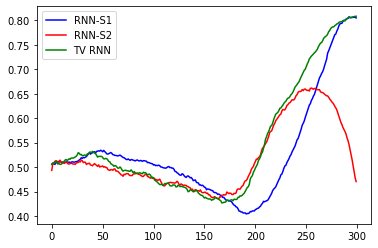

In [5]:
plt.plot(np.mean(save_val_S1,axis=0),label='RNN-S1',color='blue')
plt.plot(np.mean(save_val_S2,axis=0),label='RNN-S2',color='red')
plt.plot(np.mean(save_val_tv,axis=0),label='TV RNN',color='green')
plt.legend()
plt.show()

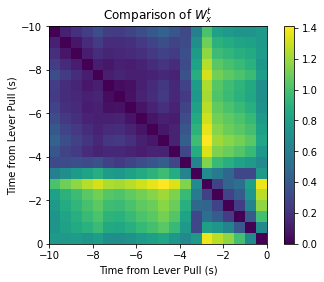

In [6]:
ed_hh,ed_ih,ed_hh_b,ed_ih_b,ed_o,ed_o_b=analysis.weights_analysis(model_tv)
plt.imshow(ed_ih,extent=[-10,0,0,-10])
cbar=plt.colorbar()
plt.xlabel('Time from Lever Pull (s)')
plt.ylabel('Time from Lever Pull (s)')
plt.title('Comparison of '+r'$W_{x}^{t}$')
plt.show()